<a href="https://colab.research.google.com/github/LindaSekhoasha/POS_Tagging/blob/main/POS_Tagging_FINAL_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meet Our Group



*   Linda Sekhoasha (222004139)
*   Wandile Ngobese (222056013)
*   Khonzinkosi Mkhize (219005273)
*   Samukelo Mkhize (220009930)

# Imports

In [1]:
!pip install datasets
!pip install sklearn-crfsuite

In [2]:
import pandas as pd
from datasets import Dataset
from collections import Counter, defaultdict, namedtuple
import nltk
from nltk.tag import hmm
from nltk.probability import LidstoneProbDist, ConditionalFreqDist, ConditionalProbDist
from nltk.tag.hmm import HiddenMarkovModelTagger
from nltk.tag.hmm import HiddenMarkovModelTrainer
from nltk.probability import DictionaryProbDist
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Pre-processing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv(r"/content/drive/MyDrive/dataset/zu.gold.seg.data", delimiter='\t')
df.head(3)

,TOKEN,MORPH ANALYSIS,UPOS
0,Ukwengeza,u-kw-engez-a,V
1,kulokhu,ku-lokhu,CDEM
2,",",",",PUNC


In [5]:
# drop/remove the MORPH ANALYSIS column
df = df.drop(columns=['MORPH ANALYSIS'])

# convert all tokens to lowercase for a consistent vocab
df['TOKEN'] = [token.lower() for token in df['TOKEN']]
df.head(10)

,TOKEN,UPOS
0,ukwengeza,V
1,kulokhu,CDEM
2,",",PUNC
3,imibandela,N
4,iyenziwa,V
5,ukwakha,V
6,amakomiti,N
7,amawadi,N
8,",",PUNC
9,njengezinhlangano,ADV


In [6]:
# convert panda dataframe to HuggingFace dataset
dataset = Dataset.from_pandas(df)
print(dataset.features)

{'TOKEN': Value(dtype='string', id=None), 'UPOS': Value(dtype='string', id=None)}


## Sentence generation
This converts token-tag pair to sentences by using the basic assumption that sentences are terminated with punctuations such as the full stop.

In [7]:
"""
This code block implements a for loop that generates sentences
from the dataset in the form -> [(w1, t1), (w2, t2), ..., (wn, tn)]
"""
sentences = []
current_sentence = []

for example in dataset:
    token = example["TOKEN"]
    tag = example["UPOS"]

    if token is None or tag is None:
        continue  # skip bad data

    current_sentence.append((token, tag))

    # sentence ends at a full stop or other terminating punctuations
    if token in [".", "!", "?"] and tag == "PUNC":
        sentences.append(current_sentence)
        current_sentence = []

# add the last sentence if the dataset doesn't end with punctuation
if current_sentence:
    sentences.append(current_sentence)

print(f"Total sentences: {len(sentences)}")

Total sentences: 3155


## Train-Test Split (with randomness)

In [8]:
train_data, test_data = train_test_split(sentences, test_size=0.2, random_state=42)

# HMM Model

## Basic Model (lower accuracy)

In [9]:
trainer = hmm.HiddenMarkovModelTrainer()
hmm_tagger1 = trainer.train(train_data)

accuracy = hmm_tagger1.accuracy(test_data)
print(f"Accuracy Score: {accuracy:.2%}")

# tagging a sentence from test data
pred_sentence = test_data[0]
new_sentence = []
for i in range(len(pred_sentence)):
    new_sentence.append(pred_sentence[i][0])

tagged_sentence = hmm_tagger1.tag(new_sentence)

print()
print(f"Actual Sentence (No tags):\n{new_sentence}")
print()
print(f"Actual Sentence (To Predict):\n{pred_sentence}")
print()
print(f"Tagged Sentence (Predicted):\n{tagged_sentence}")
print()

/usr/local/lib/python3.11/dist-packages/nltk/tag/hmm.py:335: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
/usr/local/lib/python3.11/dist-packages/nltk/tag/hmm.py:333: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
/usr/local/lib/python3.11/dist-packages/nltk/tag/hmm.py:331: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
/usr/local/lib/python3.11/dist-packages/nltk/tag/hmm.py:363: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


Accuracy Score: 40.06%

Actual Sentence (No tags):
['gcwalisa', 'umsebenzi', 'umuntu', 'awenzayo', 'esikhathini', 'esibhaliwe', ',', 'nokuthi', 'umsebenzi', 'uyakhokhelwa', 'yini', ',', 'nokuthi', 'ukhokhela', 'malini', 'ngehora', '.']

Actual Sentence (To Predict):
[('gcwalisa', 'V'), ('umsebenzi', 'N'), ('umuntu', 'N'), ('awenzayo', 'REL'), ('esikhathini', 'REL'), ('esibhaliwe', 'REL'), (',', 'PUNC'), ('nokuthi', 'ADV'), ('umsebenzi', 'N'), ('uyakhokhelwa', 'V'), ('yini', 'INT'), (',', 'PUNC'), ('nokuthi', 'ADV'), ('ukhokhela', 'V'), ('malini', 'N'), ('ngehora', 'N'), ('.', 'PUNC')]

Tagged Sentence (Predicted):
[('gcwalisa', 'N'), ('umsebenzi', 'N'), ('umuntu', 'N'), ('awenzayo', 'N'), ('esikhathini', 'N'), ('esibhaliwe', 'N'), (',', 'N'), ('nokuthi', 'N'), ('umsebenzi', 'N'), ('uyakhokhelwa', 'N'), ('yini', 'N'), (',', 'N'), ('nokuthi', 'N'), ('ukhokhela', 'N'), ('malini', 'N'), ('ngehora', 'N'), ('.', 'N')]



## Advanced HMM
This Hidden Markov Model implementation uses HiddenMarkovModelTagger from nltk, which allows you to manually define the parameters for the tagging.

In [10]:
# extract states (tags) and symbols (words)
states = set()
symbols = set()
for sentence in train_data:
    for word, tag in sentence:
        states.add(tag)
        symbols.add(word)

states = list(states)
symbols = list(symbols)

# compute frequencies for transitions, emissions, and priors (parameters)
transition_cfd = ConditionalFreqDist()
emission_cfd = ConditionalFreqDist()
prior_fd = nltk.FreqDist()

In [11]:
for sentence in train_data:
    prior_fd[sentence[0][1]] += 1  # first tag in sentence
    for i, (word, tag) in enumerate(sentence):
        emission_cfd[tag][word] += 1
        if i > 0:
            prev_tag = sentence[i - 1][1]
            transition_cfd[prev_tag][tag] += 1

In [12]:
# convert frequency distributions to probability distributions
def lidstone_cpd(cfd):
    return ConditionalProbDist(cfd, lambda fd: LidstoneProbDist(fd, 0.01))

transitions = lidstone_cpd(transition_cfd)
outputs = lidstone_cpd(emission_cfd)
priors = LidstoneProbDist(prior_fd, 0.01)

In [13]:
hmm_tagger = HiddenMarkovModelTagger(
    symbols=symbols,
    states=states,
    transitions=transitions,
    outputs=outputs,
    priors=priors
)

In [14]:
# tagging a sentence from test data
pred_sentence = test_data[0]
new_sentence = []
for i in range(len(pred_sentence)):
    new_sentence.append(pred_sentence[i][0])

tagged_sentence = hmm_tagger.tag(new_sentence)

print()
print(f"Actual Sentence (No tags):\n{new_sentence}")
print()
print(f"Actual Sentence (To Predict):\n{pred_sentence}")
print()
print(f"Tagged Sentence (Predicted):\n{tagged_sentence}")
print()


Actual Sentence (No tags):
['gcwalisa', 'umsebenzi', 'umuntu', 'awenzayo', 'esikhathini', 'esibhaliwe', ',', 'nokuthi', 'umsebenzi', 'uyakhokhelwa', 'yini', ',', 'nokuthi', 'ukhokhela', 'malini', 'ngehora', '.']

Actual Sentence (To Predict):
[('gcwalisa', 'V'), ('umsebenzi', 'N'), ('umuntu', 'N'), ('awenzayo', 'REL'), ('esikhathini', 'REL'), ('esibhaliwe', 'REL'), (',', 'PUNC'), ('nokuthi', 'ADV'), ('umsebenzi', 'N'), ('uyakhokhelwa', 'V'), ('yini', 'INT'), (',', 'PUNC'), ('nokuthi', 'ADV'), ('ukhokhela', 'V'), ('malini', 'N'), ('ngehora', 'N'), ('.', 'PUNC')]

Tagged Sentence (Predicted):
[('gcwalisa', 'CDEM'), ('umsebenzi', 'N'), ('umuntu', 'N'), ('awenzayo', 'FOR'), ('esikhathini', 'FOR'), ('esibhaliwe', 'FOR'), (',', 'PUNC'), ('nokuthi', 'ADV'), ('umsebenzi', 'N'), ('uyakhokhelwa', 'NUM'), ('yini', 'INT'), (',', 'PUNC'), ('nokuthi', 'ADV'), ('ukhokhela', 'PUNC'), ('malini', 'V'), ('ngehora', 'ADV'), ('.', 'PUNC')]



### Accuracy Score

In [15]:
# strip the words only for prediction
test_words = [[word for word, tag in sentence] for sentence in test_data]
true_tags = [[tag for word, tag in sentence] for sentence in test_data]

# tag the test words
predicted_tags = [hmm_tagger.tag(sentence) for sentence in test_words]

# extract the tags only
predicted_only = [[tag for word, tag in sent] for sent in predicted_tags]

# compute accuracy
correct = total = 0
for pred, true in zip(predicted_only, true_tags):
    for p, t in zip(pred, true):
        total += 1
        if p == t:
            correct += 1

accuracy_hmm = correct / total
print(f"Accuracy Score For Advanced HMM: {accuracy_hmm:.2%}")


Accuracy Score For Advanced HMM: 70.40%


# CRF

In [16]:
# feature extraction for a single token
def word2features(sent, i):
    word = sent[i][0]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True  # beginning of sentence

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True  # end of sentence

    return features

# transform dataset (to include features)
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# train CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',   # optimization algorithm
    c1=0.1,              # L1 regularization
    c2=0.1,              # L2 regularization
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

# predict on test set
y_pred = crf.predict(X_test)

In [17]:
# predicting sentence from test
test_sentence = X_test[0]
actual_sentence = y_test[0]

# predict tags for the test sentence
predicted_tags = crf.predict([test_sentence])[0]  # predict tags for the selected sentence

print(f"Actual Sentence (To Predict):")
print(sent2tokens(sentences[0]))  # print the original tokens from the sentence
print()

print(f"Tagged Sentence (Predicted):")
print(list(zip(sent2tokens(sentences[0]), predicted_tags)))  # print the tokens and predicted tags
print()

Actual Sentence (To Predict):
['ukwengeza', 'kulokhu', ',', 'imibandela', 'iyenziwa', 'ukwakha', 'amakomiti', 'amawadi', ',', 'njengezinhlangano', 'ezelulekayo', ',', 'lawa', 'maqembu', 'ahlanganisa', 'abamele', 'umasipala', 'kanye', 'nomphakathi', 'ukuba', 'badlulise', 'izidingo', 'zomphakathi', 'kanye', 'neziphakamiso', 'ziye', 'kumkhandlu', '.']

Tagged Sentence (Predicted):
[('ukwengeza', 'V'), ('kulokhu', 'N'), (',', 'N'), ('imibandela', 'REL'), ('iyenziwa', 'REL'), ('ukwakha', 'REL'), ('amakomiti', 'PUNC'), ('amawadi', 'ADV'), (',', 'N'), ('njengezinhlangano', 'V'), ('ezelulekayo', 'INT'), (',', 'PUNC'), ('lawa', 'ADV'), ('maqembu', 'V'), ('ahlanganisa', 'V'), ('abamele', 'ADV'), ('umasipala', 'PUNC')]



## Accuracy Score

In [18]:
# evaluation of crf model
accuracy_crf = metrics.flat_accuracy_score(y_test, y_pred)
print(f"Accuracy Score For Linear CRF: {accuracy_crf:.2%}")
print()
print("Classification Report:\n", metrics.flat_classification_report(y_test, y_pred))

Accuracy Score For Linear CRF: 83.16%

Classification Report:
               precision    recall  f1-score   support

        ABBR       0.83      0.63      0.72        30
         ADJ       0.96      0.86      0.91       154
         ADV       0.87      0.79      0.83      1569
        CDEM       0.88      0.86      0.87       249
        CONJ       0.95      0.92      0.94       632
         COP       0.78      0.31      0.44       177
         FOR       0.71      0.74      0.72        23
        IDEO       1.00      0.83      0.91         6
         INT       1.00      0.83      0.91        36
           N       0.82      0.88      0.85      2545
         NUM       1.00      0.77      0.87        31
        POSS       0.77      0.82      0.80      1634
         PRO       0.99      0.90      0.94       152
        PUNC       1.00      1.00      1.00      1431
         REL       0.76      0.64      0.70      1173
           V       0.73      0.82      0.77      2010

    accuracy     

# MEMM

In [19]:
# feature extraction for a token
def extract_features(sent, i, prev_tag):
    word = sent[i][0]
    features = {
        'word.lower()': word.lower(),
        'word.istitle()': word.istitle(),
        'word.isupper()': word.isupper(),
        'prev_tag': prev_tag
    }
    if i > 0:
        features['-1:word.lower()'] = sent[i - 1][0].lower()
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        features['+1:word.lower()'] = sent[i + 1][0].lower()
    else:
        features['EOS'] = True

    return features

# extract features and labels from training data
X_train, y_train = [], []
for sent in train_data:
    prev_tag = "<START>"
    for i in range(len(sent)):
        feats = extract_features(sent, i, prev_tag)
        X_train.append(feats)
        y_train.append(sent[i][1])
        prev_tag = sent[i][1]

# vectorize features and encode labels
vec = DictVectorizer(sparse=False)
label_encoder = LabelEncoder()

X_train_vectorized = vec.fit_transform(X_train)
y_train_encoded = label_encoder.fit_transform(y_train)

# train the MEMM (Logistic Regression)
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_vectorized, y_train_encoded)

# tagging function (using greedy decoding)
def memm_tag(sent):
    tagged = []
    prev_tag = "<START>"
    for i in range(len(sent)):
        feats = extract_features(sent, i, prev_tag)
        X_test = vec.transform([feats])
        y_pred = clf.predict(X_test)
        tag = label_encoder.inverse_transform(y_pred)[0]
        tagged.append((sent[i][0], tag))
        prev_tag = tag
    return tagged

In [20]:
# tagging a sentence using memm
test_sentence = test_data[0]

print(f"Actual Sentence (To Predict):")
print([word for word, _ in test_sentence])
print()

tagged_sentence = memm_tag(test_sentence)

print(f"Tagged Sentence (Predicted):")
print(tagged_sentence)

Actual Sentence (To Predict):
['gcwalisa', 'umsebenzi', 'umuntu', 'awenzayo', 'esikhathini', 'esibhaliwe', ',', 'nokuthi', 'umsebenzi', 'uyakhokhelwa', 'yini', ',', 'nokuthi', 'ukhokhela', 'malini', 'ngehora', '.']

Tagged Sentence (Predicted):
[('gcwalisa', np.str_('V')), ('umsebenzi', np.str_('N')), ('umuntu', np.str_('N')), ('awenzayo', np.str_('REL')), ('esikhathini', np.str_('REL')), ('esibhaliwe', np.str_('REL')), (',', np.str_('PUNC')), ('nokuthi', np.str_('ADV')), ('umsebenzi', np.str_('N')), ('uyakhokhelwa', np.str_('POSS')), ('yini', np.str_('INT')), (',', np.str_('PUNC')), ('nokuthi', np.str_('ADV')), ('ukhokhela', np.str_('V')), ('malini', np.str_('V')), ('ngehora', np.str_('ADV')), ('.', np.str_('PUNC'))]


## Accuracy Score

In [21]:
# evaluate accuracy on test_data
y_true = []
y_pred = []

for sent in test_data:
    predicted = memm_tag(sent)
    y_true.extend([true_tag for _, true_tag in sent])
    y_pred.extend([pred_tag for _, pred_tag in predicted])

accuracy_memm = accuracy_score(y_true, y_pred)
print(f"Accuracy Score For MEMM: {accuracy_memm:.2%}")
print()
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

Accuracy Score For MEMM: 81.28%

Classification Report:
              precision    recall  f1-score   support

        ABBR       1.00      0.40      0.57        25
         ADJ       1.00      0.74      0.85       130
         ADV       0.87      0.75      0.80      1295
        CDEM       0.89      0.80      0.84       208
        CONJ       0.94      0.92      0.93       505
         COP       0.93      0.26      0.41       148
         FOR       0.00      0.00      0.00        13
        IDEO       1.00      0.75      0.86         4
         INT       1.00      0.84      0.92        32
           N       0.80      0.87      0.83      2070
         NUM       1.00      0.38      0.56        26
        POSS       0.70      0.83      0.76      1350
         PRO       0.99      0.86      0.92       125
        PUNC       1.00      1.00      1.00      1172
         REL       0.73      0.62      0.67       954
           V       0.74      0.79      0.77      1622

    accuracy            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# COMPARISON

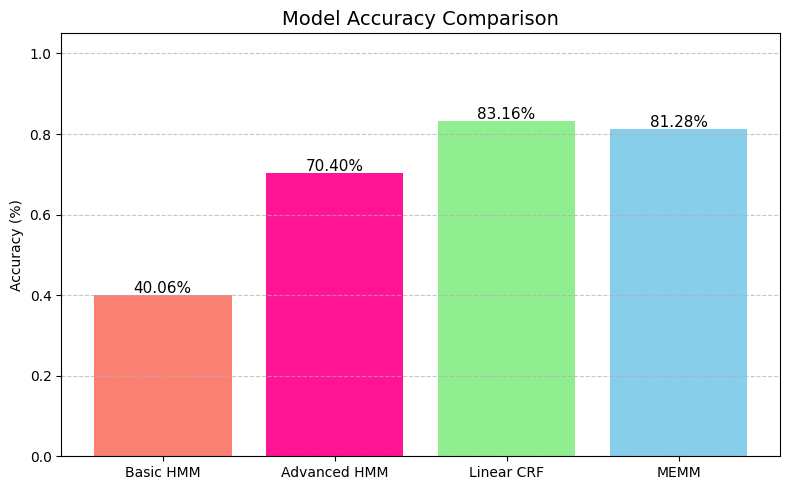

In [22]:
models = ['Basic HMM', 'Advanced HMM', 'Linear CRF', 'MEMM']
accuracies = [accuracy, accuracy_hmm, accuracy_crf, accuracy_memm]

# plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['salmon', 'deeppink', 'lightgreen', 'skyblue'])

# annotate the bars with percentage values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{acc:.2%}", ha='center', fontsize=11)

# chart styling
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()